In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE 
import pickle
import re

In [3]:
data = pd.read_csv("amazon.tsv", delimiter = '\t')

In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [6]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
data.dropna(inplace=True)

In [9]:
data.shape

(3149, 5)

In [10]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column
data['length'] = data['verified_reviews'].apply(len)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
#Randomly checking for 10th record
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}")
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")

'verified_reviews' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
Length of review : 63
'length' column value : 63


In [13]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [14]:
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


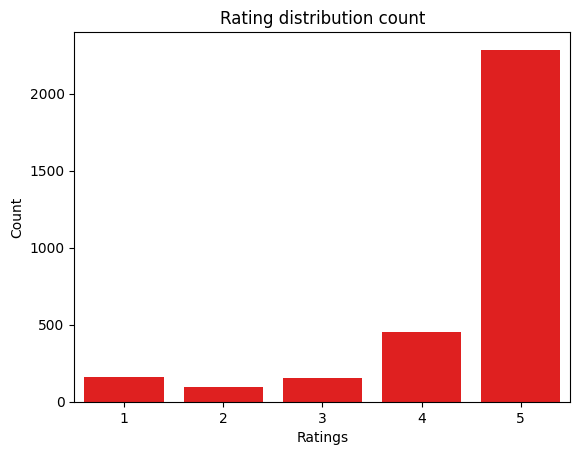

In [15]:
rating_counts = data['rating'].value_counts()
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [16]:
total_count = data.shape[0]
percentage_distribution = (rating_counts / total_count) * 100
rounded_percentage_distribution = percentage_distribution.round(2)
print(f"Rating value percentage distribution: \n{rounded_percentage_distribution}")

Rating value percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of rating'>

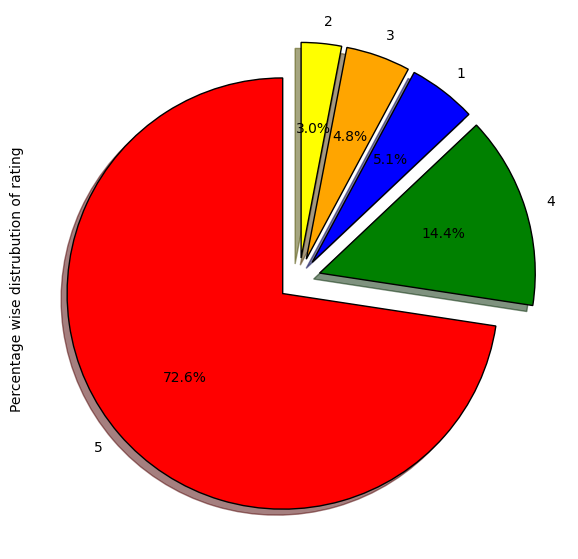

In [17]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue','orange','yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

In [18]:
feedback_value = data['feedback'].value_counts()
print(f"Feedback Value Count : \n{feedback_value}")

Feedback Value Count : 
feedback
1    2893
0     256
Name: count, dtype: int64


In [19]:
#Extracting the 'verified_reviews' value for one record with feedback = 0 and feedback = 1
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Sound is terrible if u want good music too get a bose
Loved it!


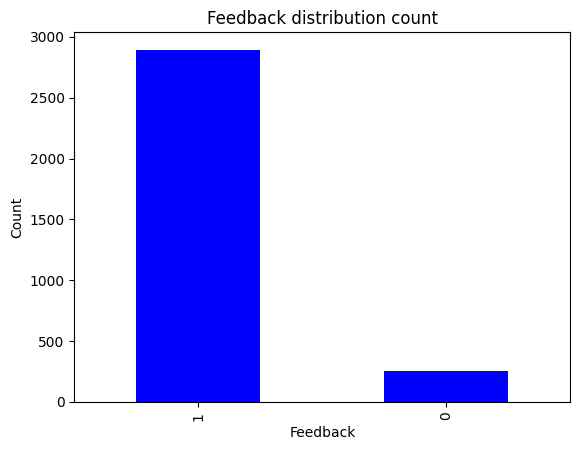

In [20]:
#Bar graph to visualize the total counts of each feedback
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [21]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [22]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [23]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [24]:
#Distinct values of 'variation' and its count
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


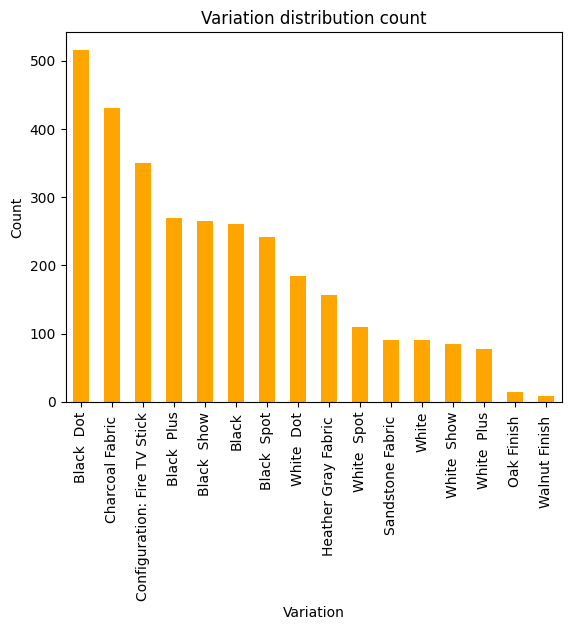

In [25]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [26]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

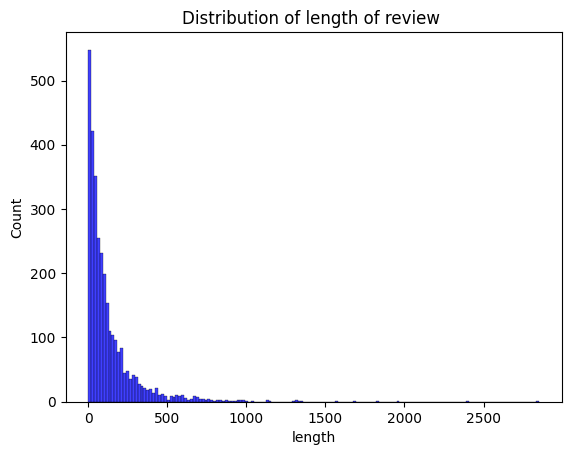

In [27]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

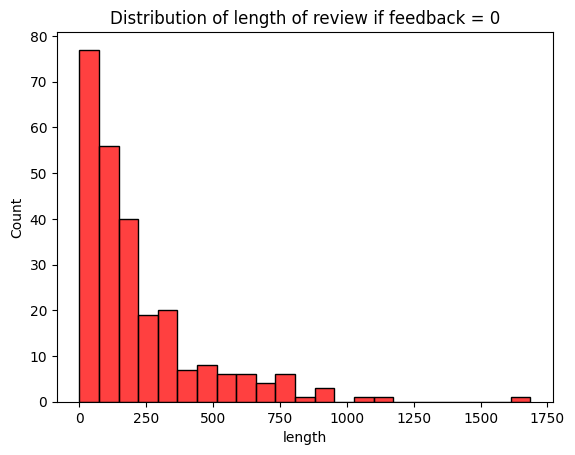

In [28]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

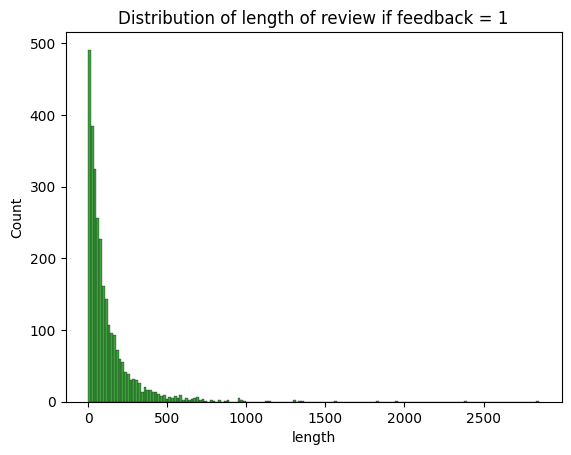

In [29]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

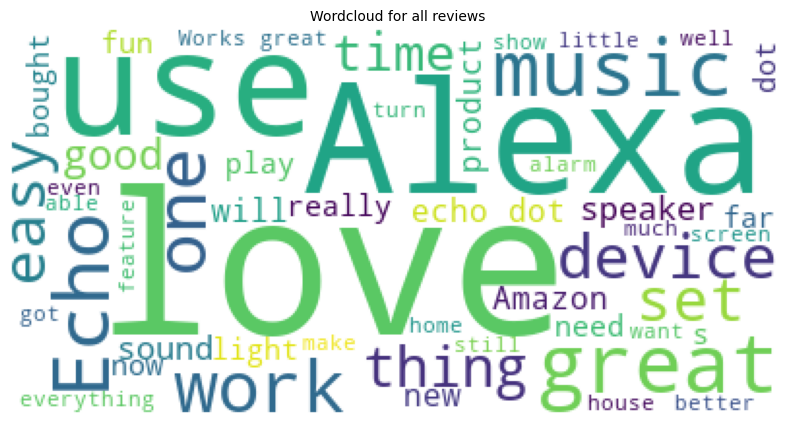

In [30]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [31]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

In [32]:
#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

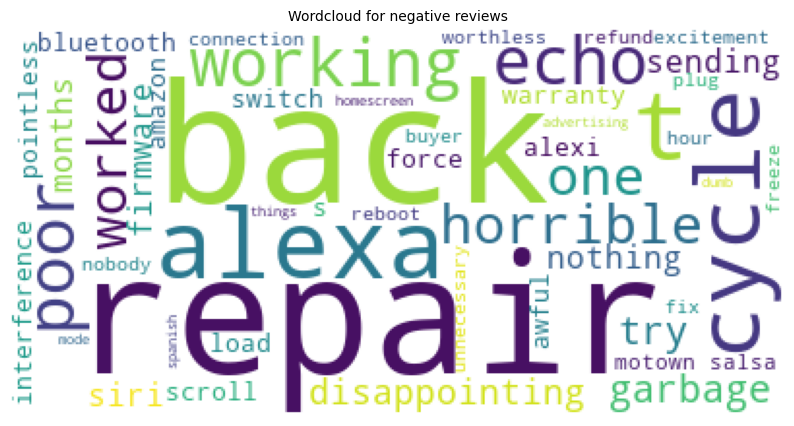

In [33]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

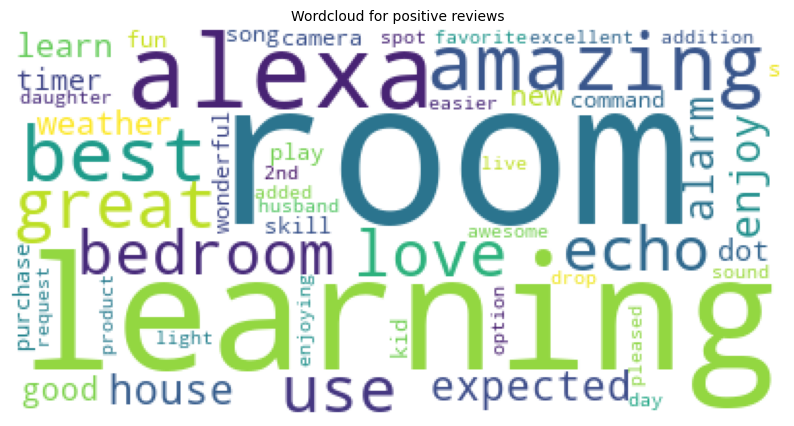

In [34]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [35]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [36]:
# Vectorization using CountVectorizer
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [37]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [38]:
# Save the CountVectorizer model
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [39]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (5786, 2500)
y shape: (5786,)


In [40]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [41]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [42]:
# Save the scaler
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [43]:
# Random Forest Classifier with class weight to handle imbalance
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_scl, y_train)

RandomForestClassifier(class_weight='balanced')

In [44]:
# Model evaluation on training and testing data
rf_train_acc = rf.score(X_train_scl, y_train)
rf_test_acc = rf.score(X_test_scl, y_test)

In [45]:
print(f"Training Accuracy (RandomForest): {rf_train_acc:.2f}")
print(f"Testing Accuracy (RandomForest): {rf_test_acc:.2f}")

Training Accuracy (RandomForest): 0.98
Testing Accuracy (RandomForest): 0.95


In [46]:
y_preds_rf = rf.predict(X_test_scl)

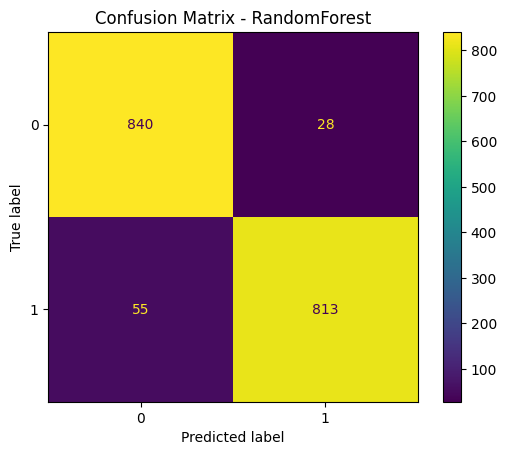

In [47]:
cm_rf = confusion_matrix(y_test, y_preds_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
cm_display_rf.plot()
plt.title("Confusion Matrix - RandomForest")
plt.show()

In [48]:
# Cross-validation
accuracies_rf = cross_val_score(estimator=rf, X=X_train_scl, y=y_train, cv=10)
print("Cross-validation Accuracy (RandomForest):", accuracies_rf.mean())
print("Standard Variance:", accuracies_rf.std())

Cross-validation Accuracy (RandomForest): 0.9424691358024692
Standard Variance: 0.012348147901283935


In [49]:
print("Classification Report (RandomForest):\n", classification_report(y_test, y_preds_rf))

Classification Report (RandomForest):
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       868
           1       0.97      0.94      0.95       868

    accuracy                           0.95      1736
   macro avg       0.95      0.95      0.95      1736
weighted avg       0.95      0.95      0.95      1736



In [50]:
pickle.dump(rf, open('Models/model_rf.pkl', 'wb'))

In [51]:
# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
xgb_train_acc = xgb.score(X_train_scl, y_train)
xgb_test_acc = xgb.score(X_test_scl, y_test)
print(f"Training Accuracy (XGBoost):{xgb_train_acc : 0.2f}")
print(f"Testing Accuracy (XGBoost):{xgb_test_acc : 0.2f}")

Training Accuracy (XGBoost): 0.95
Testing Accuracy (XGBoost): 0.93


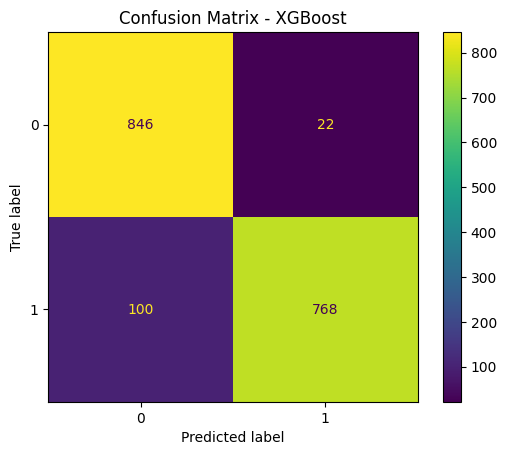

In [53]:
y_preds_xgb = xgb.predict(X_test_scl)
cm_xgb = confusion_matrix(y_test, y_preds_xgb)
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
cm_display_xgb.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [54]:
print("Classification Report (XGBoost):\n", classification_report(y_test, y_preds_xgb))

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       868
           1       0.97      0.88      0.93       868

    accuracy                           0.93      1736
   macro avg       0.93      0.93      0.93      1736
weighted avg       0.93      0.93      0.93      1736



In [55]:
pickle.dump(xgb, open('Models/model_xgb.pkl', 'wb'))

In [56]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train_scl, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [57]:
dt_train_acc = dt.score(X_train_scl, y_train)
dt_test_acc = dt.score(X_test_scl, y_test)
print(f"Training Accuracy (DecisionTree):{dt_train_acc : 0.2f}")
print(f"Testing Accuracy (DecisionTree):{dt_test_acc:0.2f}")

Training Accuracy (DecisionTree): 0.98
Testing Accuracy (DecisionTree):0.94


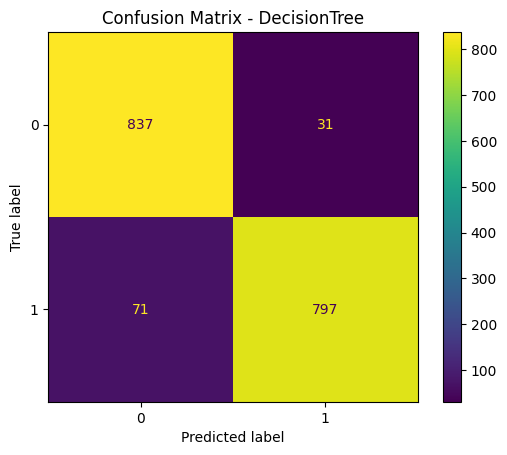

In [58]:
y_preds_dt = dt.predict(X_test_scl)
cm_dt = confusion_matrix(y_test, y_preds_dt)
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
cm_display_dt.plot()
plt.title("Confusion Matrix - DecisionTree")
plt.show()

In [59]:
print("Classification Report (DecisionTree):\n", classification_report(y_test, y_preds_dt))

Classification Report (DecisionTree):
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       868
           1       0.96      0.92      0.94       868

    accuracy                           0.94      1736
   macro avg       0.94      0.94      0.94      1736
weighted avg       0.94      0.94      0.94      1736



In [60]:
pickle.dump(dt, open('Models/model_dt.pkl', 'wb'))

In [61]:
model_names = ['RandomForest', 'XGBoost', 'DecisionTree']
train_accu = [rf_train_acc, xgb_train_acc, dt_train_acc]
test_accu = [rf_test_acc, xgb_test_acc, dt_test_acc]

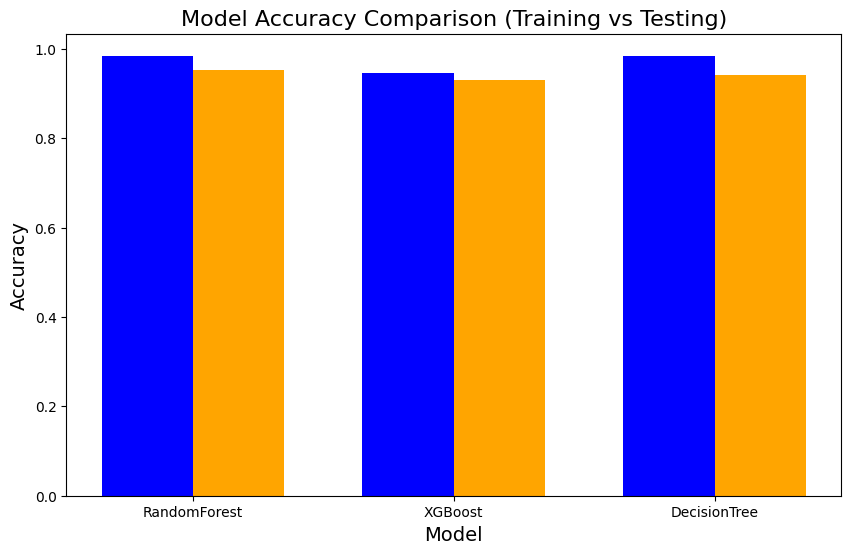

In [62]:
bar_width = 0.35
index = np.arange(len(model_names))
plt.figure(figsize=(10, 6))
plt.bar(index, train_accu, bar_width, label='Training Accuracy', color='blue')
plt.bar(index + bar_width, test_accu, bar_width, label='Testing Accuracy', color='orange')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Comparison (Training vs Testing)', fontsize=16)
plt.xticks(index + bar_width / 2, model_names)
plt.show()